<a href="https://colab.research.google.com/github/jihuitong/vit-base/blob/main/vit_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision timm tqdm --quiet

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import timm  # PyTorch Image Models库，包含各种预训练模型
from tqdm import tqdm
from torch.utils.data import random_split
import copy

In [6]:
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
}

data_dir = './data'

# 下载 CIFAR-10 训练集
full_train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=data_transforms['train'])

# 划分训练集和验证集
train_size = 45000
val_size = len(full_train_dataset) - train_size
train_dataset, val_subset = random_split(full_train_dataset, [train_size, val_size])

# 创建独立的验证集
val_dataset = copy.deepcopy(full_train_dataset)
val_dataset.transform = data_transforms['val']
val_subset = torch.utils.data.Subset(val_dataset, val_subset.indices)

# 下载 CIFAR-10 测试集
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=data_transforms['val'])

# 定义数据加载器
batch_size = 64
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = full_train_dataset.classes

print(f"训练集大小: {dataset_sizes['train']}")
print(f"验证集大小: {dataset_sizes['val']}")
print(f"测试集大小: {dataset_sizes['test']}")
print(f"类别名称: {class_names}")


100%|██████████| 170M/170M [00:08<00:00, 20.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
训练集大小: 45000
验证集大小: 5000
测试集大小: 10000
类别名称: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda:0


In [8]:
# 加载预训练的 Vision Transformer 模型
model_name = 'vit_base_patch16_224'  # 可以选择不同的ViT模型
model = timm.create_model(model_name, pretrained=True)

# 修改最后的分类头适应 CIFAR-10
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(class_names))

# 冻结所有参数
for param in model.parameters():
    param.requires_grad = False

# 只训练分类头的参数
for param in model.head.parameters():
    param.requires_grad = True

model = model.to(device)

print("模型结构：")
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

模型结构：
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Ide

In [9]:
criterion = nn.CrossEntropyLoss()

# 只优化分类头的参数
optimizer = optim.Adam(model.head.parameters(), lr=3e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch +1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(total=dataset_sizes[phase], desc=f'{phase.capitalize()}') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    pbar.update(inputs.size(0))
                    pbar.set_postfix({'Loss': loss.item()})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                learning_rates.append(optimizer.param_groups[0]['lr'])
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

        print()

    time_elapsed = time.time() - since
    print(f'训练完成耗时 {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'最佳验证准确率: {best_acc:.4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates
    }

    return model, history


In [12]:
# 训练模型
num_epochs = 5
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/5
----------


Train: 100%|██████████| 45000/45000 [08:20<00:00, 89.85it/s, Loss=0.631]


train Loss: 0.1434 Acc: 0.9671


Val: 100%|██████████| 5000/5000 [00:56<00:00, 88.00it/s, Loss=0.0492]


val Loss: 0.0871 Acc: 0.9734

Epoch 2/5
----------


Train: 100%|██████████| 45000/45000 [08:27<00:00, 88.68it/s, Loss=0.0349]


train Loss: 0.0729 Acc: 0.9782


Val: 100%|██████████| 5000/5000 [00:56<00:00, 88.52it/s, Loss=0.0146]


val Loss: 0.0767 Acc: 0.9750

Epoch 3/5
----------


Train: 100%|██████████| 45000/45000 [08:27<00:00, 88.66it/s, Loss=0.0184]


train Loss: 0.0603 Acc: 0.9812


Val: 100%|██████████| 5000/5000 [00:56<00:00, 88.56it/s, Loss=0.00784]


val Loss: 0.0749 Acc: 0.9758

Epoch 4/5
----------


Train: 100%|██████████| 45000/45000 [08:27<00:00, 88.65it/s, Loss=0.121]


train Loss: 0.0524 Acc: 0.9832


Val: 100%|██████████| 5000/5000 [00:56<00:00, 88.15it/s, Loss=0.00492]


val Loss: 0.0718 Acc: 0.9766

Epoch 5/5
----------


Train: 100%|██████████| 45000/45000 [08:27<00:00, 88.67it/s, Loss=0.00191]


train Loss: 0.0476 Acc: 0.9849


Val: 100%|██████████| 5000/5000 [00:56<00:00, 88.13it/s, Loss=0.0042]

val Loss: 0.0714 Acc: 0.9766

训练完成耗时 46m 54s
最佳验证准确率: 0.9766


In [13]:
# 显示图像
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp * 0.5 + 0.5, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

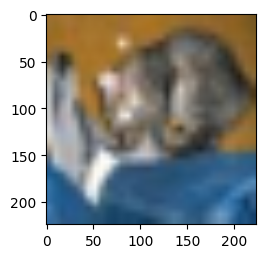

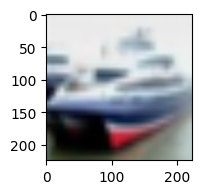

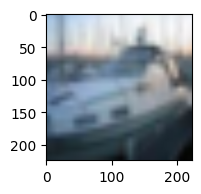

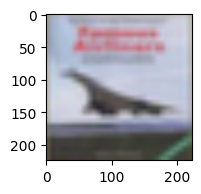

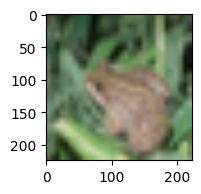

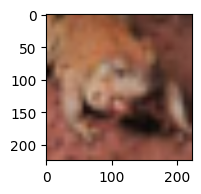

In [14]:
inputs, classes_gt = next(iter(dataloaders['test']))

inputs = inputs.to(device)
classes_gt = classes_gt.to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

inputs = inputs.cpu()
classes_gt = classes_gt.cpu()
preds = preds.cpu()

# 显示前6张图像及其预测结果
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    imshow(inputs[i])
    ax.set_title(f'GT: {class_names[classes_gt[i]]}\nPred: {class_names[preds[i]]}')
    ax.axis('off')
plt.show()


<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.
  plt.tight_layout()
<ipython-input-16-3a756e5de7de>:22: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
<ipyth

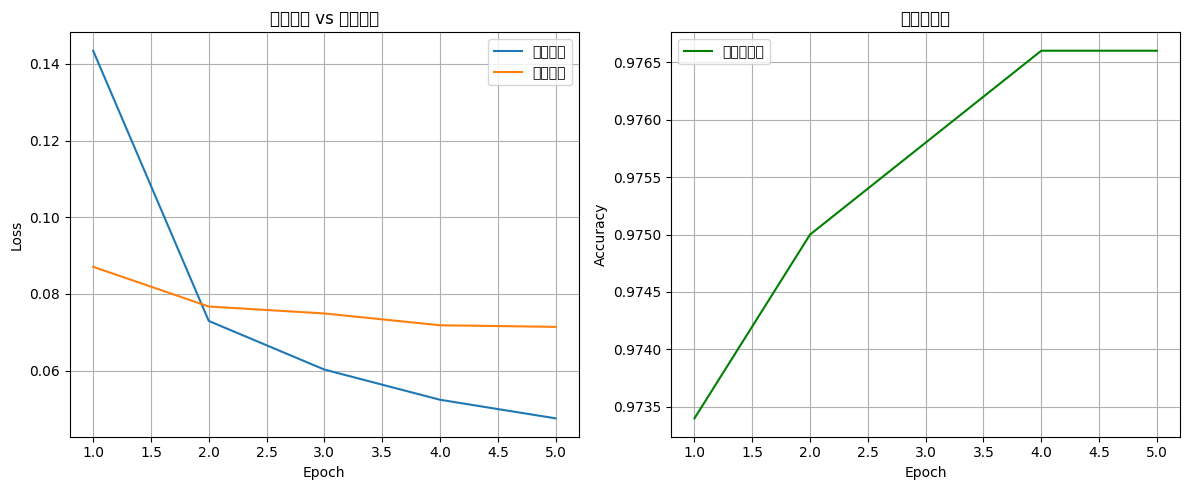

In [16]:
# 绘制训练损失和验证损失
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs +1), history['train_losses'], label='训练损失')
plt.plot(range(1, num_epochs +1), history['val_losses'], label='验证损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练损失 vs 验证损失')
plt.legend()
plt.grid(True)

# 绘制验证准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs +1), history['val_accuracies'], label='验证准确率', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('验证准确率')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# 计算整个数据集的准确率
def evaluate_model(model, dataloader_key, device):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders[dataloader_key], desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    return accuracy.item()


In [18]:
# 测试集上的准确率
test_accuracy = evaluate_model(model, 'test', device)
print(f"模型在CIFAR-10测试集上的准确率: {test_accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 157/157 [01:50<00:00,  1.42it/s]

模型在CIFAR-10测试集上的准确率: 97.74%


In [19]:
save_dir = './vit_model'
save_path = os.path.join(save_dir, 'vit_cifar10_finetuned.pth')

# 如果保存目录不存在，则创建它
os.makedirs(save_dir, exist_ok=True)

# 保存模型
torch.save(model.state_dict(), save_path)
print(f"模型已保存到 {save_path}")

模型已保存到 ./vit_model/vit_cifar10_finetuned.pth
